testing/realizations/tp\aniso=[1.0000,1.0000,1.0000]-s=1.000-R=5.000-32-grid-samples-cond.bin
(2000, 32, 32)


C:\Users\dario\AppData\Local\Temp\ipykernel_42380\1807574650.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


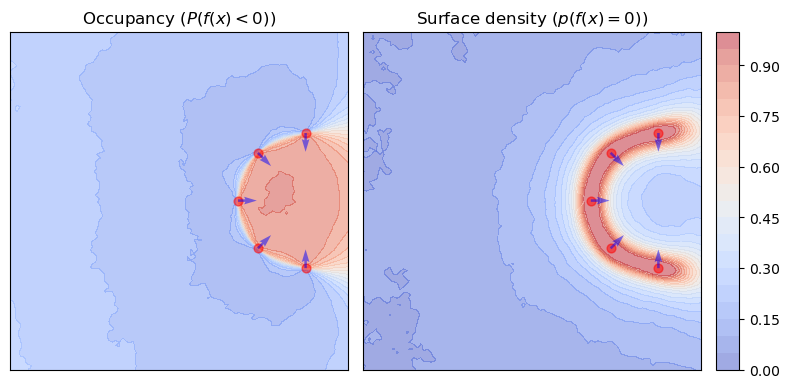

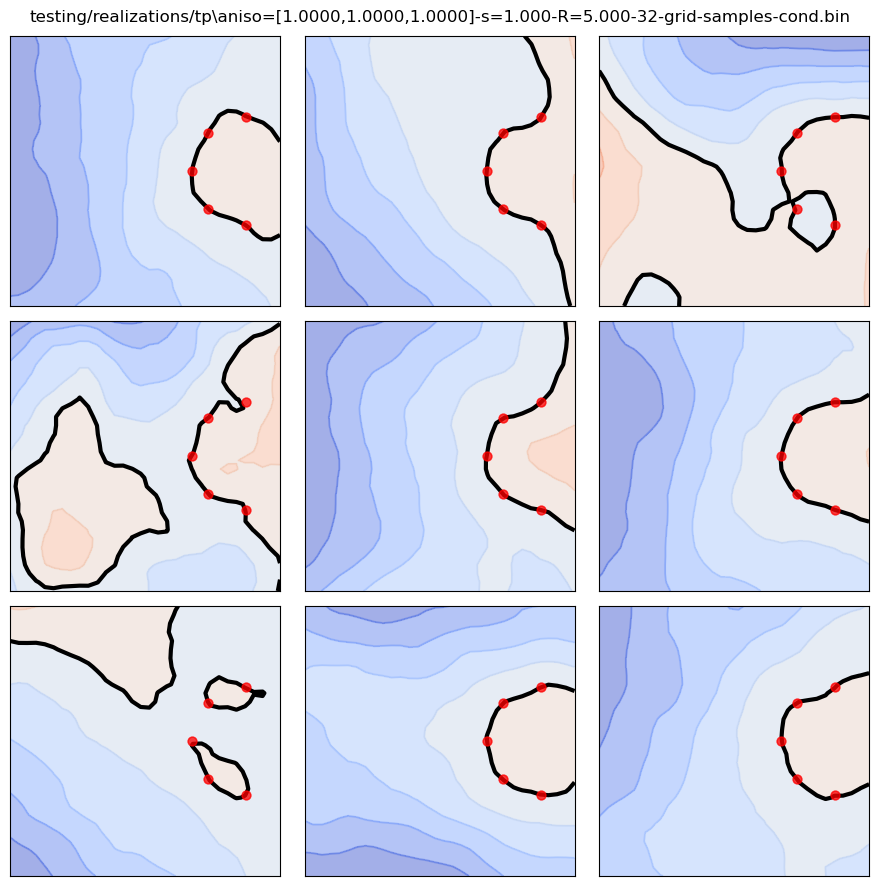

In [7]:
import os
import utils
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import scipy.interpolate as interp

res = 32

for file in glob.glob("testing/realizations/tp/*32*samples-cond.bin"):

    print(file)

    realizations = np.reshape(np.fromfile(file, dtype=np.float64), (-1, res, res))
    realizations = realizations.transpose(0, 2, 1)

    print(realizations.shape)

    cond_ps_file = file.replace("grid-samples", "cond-ps")
    if os.path.exists(cond_ps_file):
        cond_ps = np.reshape(np.fromfile(cond_ps_file, dtype=np.float64), (-1, 3))
        cond_ns = np.reshape(np.fromfile(file.replace("grid-samples", "cond-ns"), dtype=np.float64), (-1, 3))
        cond_ds = np.reshape(np.fromfile(file.replace("grid-samples", "cond-ds"), dtype=np.uint8), (-1, 1))
        cond_vs = np.reshape(np.fromfile(file.replace("grid-samples", "cond-vs"), dtype=np.float64), (-1, 1))
    else:
        cond_ps = None

    xs = np.linspace(-1, 1, realizations.shape[1])
    ys = np.linspace(-1, 1, realizations.shape[2])
    xx, yy = np.meshgrid(xs,ys)

    #fig, axs = plt.subplots(1, 2, figsize=(4*2, 4))
    fig = plt.figure(figsize=(4*2, 4))

    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,2),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

    grid_interp = interp.RegularGridInterpolator((xs, ys), realizations.transpose(2, 1, 0))
    hd_xs = np.linspace(-1, 1, 100)
    hd_ys = np.linspace(-1, 1, 100)
    hd_xx, hd_yy = np.meshgrid(hd_xs,hd_ys)

    interp_reals = np.atleast_2d(grid_interp((hd_xx, hd_yy)))

    occupancy = np.mean(interp_reals < 0, axis=2)
    cs = grid[0].contourf(hd_xx, hd_yy, occupancy, vmin=0, vmax=1, alpha=0.5, levels = np.linspace(0, 1, 21), cmap="coolwarm")
    grid[0].set_title("Occupancy ($P(f(x) < 0)$)")
    grid[0].set_xticks([])
    grid[0].set_yticks([])

    surface_density = np.mean(np.abs(interp_reals) < 0.01, axis=2)
    cs = grid[1].contourf(hd_xx, hd_yy, surface_density, vmin=0, vmax=1, alpha=0.5, levels = np.linspace(0, 1, 21), cmap="coolwarm")
    #plt.colorbar(cs)
    grid[1].set_title("Surface density ($p(f(x) = 0)$)")
    grid[1].cax.colorbar(cs)
    grid[1].cax.toggle_label(True)
    grid[1].set_xticks([])
    grid[1].set_yticks([])


    if cond_ps is not None:
        is_fo = (cond_ds == 0).flatten()
        grid[0].scatter(cond_ps[is_fo,0], cond_ps[is_fo,1], color="red", s=40, zorder=10, alpha=0.5)
        grid[1].scatter(cond_ps[is_fo,0], cond_ps[is_fo,1], color="red", s=40, zorder=10, alpha=0.5)

        is_so = ~is_fo
        if np.any(is_so):
            grid[0].quiver(
                cond_ps[is_so,0], cond_ps[is_so,1], 
                cond_ns[is_so, 0] * cond_vs[is_so, 0], cond_ns[is_so, 1] * cond_vs[is_so, 0], 
                color="blue", zorder=10, alpha=0.5)
            grid[1].quiver(
                cond_ps[is_so,0], cond_ps[is_so,1], 
                cond_ns[is_so, 0] * cond_vs[is_so, 0], cond_ns[is_so, 1] * cond_vs[is_so, 0], 
                color="blue", zorder=10, alpha=0.5)


    fig.tight_layout()

    realizations = realizations[:9]
    num_cols = 3
    num_rows = realizations.shape[0] // num_cols
    if realizations.shape[0] % num_cols != 0:
        num_rows += 1

    fig, axs = plt.subplots(num_rows, num_cols, sharex=True, sharey=True, figsize=(num_cols*3, num_rows*3))
    axs = np.atleast_1d(axs)
    axs = np.ravel(axs)
    fig.suptitle(file)


    for i in range(realizations.shape[0]):
        utils.plot_realization(realizations[i], axs[i], xx, yy)
        axs[i].set_xticks([])
        axs[i].set_yticks([])

        if cond_ps is not None:
            axs[i].scatter(cond_ps[:,0], cond_ps[:,1], color="red", s=40, zorder=10, alpha=0.5)

    fig.tight_layout()
